## All packages needed:

In [15]:
#things we need in order to import our data
import datetime
import pandas as pd
#math-stuff
import numpy as np
import matplotlib.pyplot as plt
import random as rand
import math
#This is for enabling us to interact with plots
#import mpld3
#mpld3.enable_notebook()
%matplotlib notebook

#for plotting panda stuff
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#stat stuff
import scipy.stats as ss

# ML
from sklearn.cluster import KMeans
from sklearn import mixture

# For cluster evaluation
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score

## Uploading our data:

In [2]:
hdf = pd.HDFStore(r'C:\Users\Karl\Downloads\20170101_20190101_EURUSD.h5', complib = 'zlib')
symbol = 'EURUSD'
start = pd.to_datetime('2018-01-02')
end = pd.to_datetime('2018-01-03')

ticks = hdf.select(symbol, where='index>="{}" & index<="{}"'.format(start, end))
ticks.info()
hdf.close()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 848522 entries, 2018-01-02 00:00:00.033000+00:00 to 2018-01-02 23:59:58.963000+00:00
Data columns (total 2 columns):
bid    848522 non-null float32
ask    848522 non-null float32
dtypes: float32(2)
memory usage: 12.9 MB


## Creating manageable data representations:

In [3]:
dataset = [ticks['bid'].values[0:len(ticks)], ticks['ask'].values[0:len(ticks)]]
timeset = [ticks.index[0:len(ticks)].year, ticks.index[0:len(ticks)].month, ticks.index[0:len(ticks)].day, 
           ticks.index[0:len(ticks)].hour, ticks.index[0:len(ticks)].second]

bid_ask_avg = (ticks['bid'].values[0:len(ticks)]+ticks['ask'].values[0:len(ticks)])/2

total_set = [ticks.index[0:len(ticks)].year, ticks.index[0:len(ticks)].month, 
             ticks.index[0:len(ticks)].day, ticks.index[0:len(ticks)].hour, ticks.index[0:len(ticks)].second, bid_ask_avg]

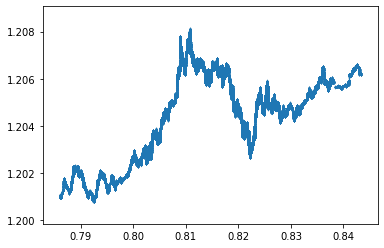

In [4]:
tidpunkt_trade = 1/(-(ticks.index.values[0:len(ticks.index)].astype('datetime64[ms]').astype(int))/(10**9))
prisdata = bid_ask_avg

data_test =[]
data_test_nbr2 = []

for i in range(0,len(ticks.index)):
    data_test.append([tidpunkt_trade[i],prisdata[i]])  #here i create a numerical representation of day,hour,second,millisecond etc)
    data_test_nbr2.append([prisdata[i],tidpunkt_trade[i]])
    
plt.figure()
plt.scatter(tidpunkt_trade,prisdata, s=0.05)

Wall time: 4min 8s


Text(0, 0.5, 'ticks at price level')

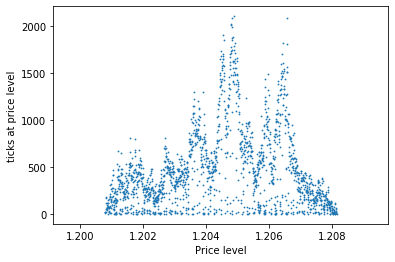

In [5]:
%%time

#Here I extract all the prevailing price levels in the data to get activity at each price level

prisnivåer = sorted(list(set(prisdata)))
aktivitet_per_prisnivå = np.zeros(len(prisnivåer))

count = 0
for i in prisnivåer:
    for ii in range(0,len(prisdata)):
        if prisdata[ii] == i:
            aktivitet_per_prisnivå[count] += 1
    count += 1
    
plt.figure()
plt.scatter(prisnivåer,aktivitet_per_prisnivå, s=0.6)
plt.xlabel('Price level')
plt.ylabel('ticks at price level')

## Prestudy of the data to see if we can find correlation between activity and fluctuation (variance)

Wall time: 4.24 s


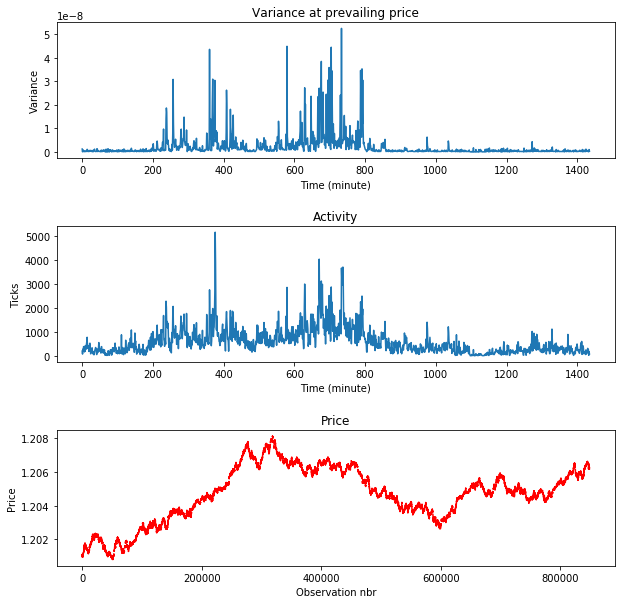

In [6]:
%%time

#this cell produces activity per minute and variance for price per minute

timestamps = ticks.index[0:len(ticks)].values
rounded_timestamps = timestamps.astype('datetime64[m]')

#variance per minute
length = len(set(rounded_timestamps.astype('datetime64[m]')))
minute_trades = set(rounded_timestamps.astype('datetime64[m]'))

var_price = np.zeros(length)
activity = np.zeros(length)

index = 0
start = 0
for i in minute_trades:
    stretch = np.count_nonzero(rounded_timestamps==i)
    activity[index] = stretch
    var_price[index] = np.var(bid_ask_avg[start:start+stretch])
    start = stretch+1
    index += 1

plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.plot(range(0,length),var_price)
plt.title('Variance at prevailing price')
plt.xlabel('Time (minute)')
plt.ylabel('Variance')

plt.subplot(3,1,2)
plt.plot(range(0,length),activity)
plt.title('Activity')
plt.xlabel('Time (minute)')
plt.ylabel('Ticks')



plt.subplot(3,1,3)
plt.plot(range(len(bid_ask_avg)),bid_ask_avg,c='r',ls='--')
plt.title('Price')
plt.xlabel('Observation nbr')
plt.ylabel('Price')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
plt.savefig("activity_price_var.png",format="png")

In [7]:
%%time

# covariance matrices
covariance_price_act = np.cov(var_price,activity)
# Pearson’s Correlation
corr_pear_price_act,_ = ss.pearsonr(var_price, activity)
# Spearman’s Correlation
corr_spear_price_act,_ = ss.spearmanr(var_price, activity)

print('#'*10 + ' Covariances ' + '#'*10 + '\n' +
     'price-activity ' + '\n'+ str(covariance_price_act) + '\n')
print('#'*10 + ' Pearson correlations ' + '#'*10 + '\n' +
     'price-activity:  ' + str(corr_pear_price_act) + '\n')
print('#'*10 + ' Spearman correlations ' + '#'*10 + '\n' +
     'price-activity:  ' + str(corr_spear_price_act) + '\n')

########## Covariances ##########
price-activity 
[[2.49642994e-17 2.04327874e-06]
 [2.04327874e-06 2.96314219e+05]]

########## Pearson correlations ##########
price-activity:  0.7512624434911381

########## Spearman correlations ##########
price-activity:  0.8278925538719138

Wall time: 1.99 ms


# Kmeans:

## Pre-process for Kmeans:

In [11]:
data_test_nbr3 = []
data_test_nbr4 = []

for i in range(0,len(prisnivåer)):
    data_test_nbr3.append([prisnivåer[i],aktivitet_per_prisnivå[i]])
    data_test_nbr4.append([aktivitet_per_prisnivå[i],prisnivåer[i]])

## Creating specialized Kmeans:

In [12]:
def extr(lst,i): 
    return [item[i] for item in lst] 

def partition(vec,nbr_clusters):
    l = len(vec)
    price = extr(vec,0)
    activity = extr(vec,1)
    labels = np.zeros(l)
    centroids = []
    start = []
    for i in range(nbr_clusters):
        pos = rand.uniform(min(price),max(price))
        centroids.append([pos,i])
        start.append([pos,i])
        
    #cont = True
    #total_iterations = 0
    #while cont:
    
        #total_iterations += 1
    for iterations in range(300):
        
        #assigning datapoints to clusters:
        count=0
        for i in price:
            dist_start = 10**8 

            for c in centroids:
                distC = abs(i-c[0])
                if distC < dist_start:
                    labels[count] = c[1]
                    dist_start = distC    
            count+=1

        #updating cluster positions:
        for c in centroids:
            lab = c[1]
            xold = c[0]
            data_belonging_to_cluster = []

            for index in range(len(vec)):
                if labels[index] == lab:
                    data_belonging_to_cluster.append(vec[index])

            #calculating center of 'mass' i.e center of activity (OBS måste ta hänsyn till vart 'roden' börjar)
            price_in_data = extr(data_belonging_to_cluster,0)
            act_in_data = extr(data_belonging_to_cluster,1)
            summation = 0
            sum_act = 0
            
            if not price_in_data: 
                x0 = 0.00001
            else:
                x0 = min(price_in_data)

            for i in data_belonging_to_cluster:
                summation+= (i[0]-x0)*i[1]
                sum_act += i[1]
            
            if sum_act == 0:
                CM = 0
            else:
                CM = summation/sum_act
            c[0] = x0+CM
            eps = abs(c[0]-xold)
            
        #if eps < 0.00001:
            #cont = False
                

    return labels,centroids,start,iterations

## Using specialized Kmeans on data and plotting results:

Wall time: 9.84 s


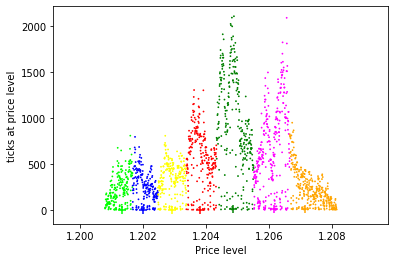

In [13]:
%%time

lb_partition,cents,cent_start,iterations = partition(data_test_nbr3,7)

colormap_test_partition = np.array(['red', 'blue', 'lime', 'yellow','magenta', 'green', 'orange'])
plt.figure()
plt.scatter(prisnivåer,aktivitet_per_prisnivå, s=0.6, c=colormap_test_partition[lb_partition.astype(int)])
plt.xlabel('Price level')
plt.ylabel('ticks at price level')
count = 0
for i in cents:
    plt.scatter(i[0],i[1],marker='+',c=colormap_test_partition[count],s=70)
    count+=1

# GMM:

## Pre-process for GMM:

In [11]:
scaled_price = np.zeros(len(prisdata))
mu = np.mean(prisdata)
std = np.std(prisdata)

count = 0
for i in prisdata:
    new_e = (i-mu)/std
    scaled_price[count] = new_e
    count+=1

scaled_price = scaled_price.reshape(-1,1)

## Using sklearn_GMM on pre-processed data and plotting results:

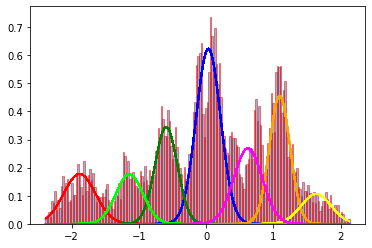

Mean: 0.00010436650475106695
Std: 0.9999999127501618


In [12]:
g = mixture.GaussianMixture(n_components=7,covariance_type='full')
g.fit(scaled_price)
weights = g.weights_
means = g.means_
covars = g.covariances_

plt.figure()
plt.hist(scaled_price,bins=200, histtype='bar', density=True, ec='red', alpha=0.5)
plt.plot(scaled_price,weights[0]*ss.norm.pdf(scaled_price,means[0],np.sqrt(covars[0])), c='red')
plt.plot(scaled_price,weights[1]*ss.norm.pdf(scaled_price,means[1],np.sqrt(covars[1])), c='blue')
plt.plot(scaled_price,weights[2]*ss.norm.pdf(scaled_price,means[2],np.sqrt(covars[2])), c='orange')
plt.plot(scaled_price,weights[3]*ss.norm.pdf(scaled_price,means[3],np.sqrt(covars[3])), c='green')
plt.plot(scaled_price,weights[4]*ss.norm.pdf(scaled_price,means[4],np.sqrt(covars[4])), c='yellow')
plt.plot(scaled_price,weights[5]*ss.norm.pdf(scaled_price,means[5],np.sqrt(covars[5])), c='lime')
plt.plot(scaled_price,weights[6]*ss.norm.pdf(scaled_price,means[6],np.sqrt(covars[6])), c='magenta')
#plt.savefig("GMM_clusters.png", format="png")
plt.show()


print('Mean: ' + str(np.mean(scaled_price)) + '\n' + 'Std: ' + str(np.std(scaled_price)))

#Creating a label vector from the GMM
lb_gmm = g.predict(scaled_price)
GMM_label_probs = g.predict_proba(scaled_price)

# Checking how GMM and Kmeans cluster our data looking at the price-over-time domain:

### Kmeans:

Wall time: 2min 3s


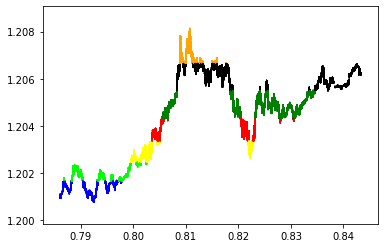

In [14]:
%%time

gruppering = np.zeros(len(prisdata))

count = 0
for i in prisdata:
    for j in range(0,len(prisnivåer)):
        if i == prisnivåer[j]: 
            #gruppering[count] = lb_kmean[j] #aktivera om vi vill köra kmean
            gruppering[count] = lb_partition[j]  #aktivera om vi vill köra partition
            #gruppering[count] = lb_gmm[j]   #aktivera om vi vill köra gmm
            #gruppering[count] = lb_DB[j]     #aktivera om vi vill köra DBscan
    count += 1

colormap = np.array(['red', 'lime', 'blue', 'yellow', 'black', 'green', 'orange', 'teal', 'magenta', 'olive'])
plt.figure()
plt.scatter(tidpunkt_trade,prisdata,c=colormap[gruppering.astype(int)], s=0.05)
#plt.savefig("partition_grp.png",format ="png")

### GMM:

<IPython.core.display.Javascript object>


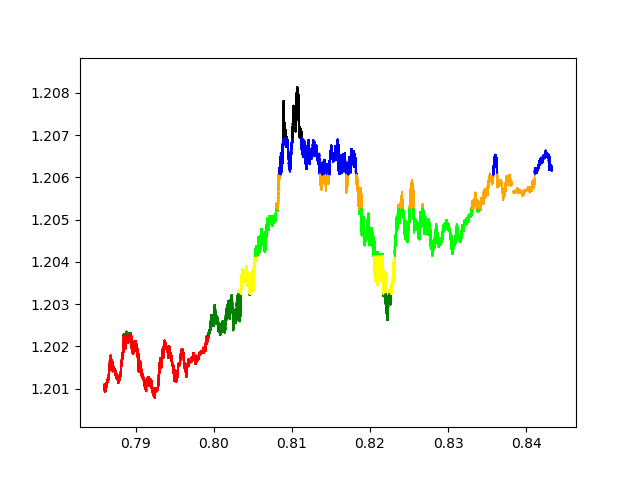

Wall time: 3.02 s


In [18]:
%%time

colormap = np.array(['red', 'lime', 'blue', 'yellow', 'black', 'green', 'orange', 'teal', 'magenta', 'olive'])
plt.figure()
#plt.scatter(tidpunkt_trade,prisdata,c=colormap[gruppering.astype(int)], s=0.05)
plt.scatter(tidpunkt_trade,prisdata,c=colormap[lb_gmm.astype(int)], s=0.05)
#plt.savefig("gmm_grouping.png",format = "png")

# Performance metrics:

## V_measure:

In [38]:
def ecount(vector,number):
    summation = 0
    for i in vector:
        if i == number:
            summation +=1
    return summation

def Vmeasure(data,labels):
    Beta = 1
    N = len(data)
    h = 1 # we only have one class label so therefore our clustering will always be completely homogenous
    
    #H_KC & H_K:
    H_KC = 0
    H_K = 0
    for i in set(labels):
        a_ck = ecount(labels,i) #how many data points that belong to each cluster
        print(a_ck)
        H_KC += (a_ck/N)*math.log(a_ck/N)
        H_K += a_ck*math.log(a_ck)
    H_KC = -H_KC
    H_K = -H_K
        
    c = 1-(H_KC/H_K)
    
    V_beta = ((1+Beta)*h*c)/(Beta*h+c)
    
    return V_beta
Vmeasure(prisdata,lb_gmm)

248005
73720
153627
90605
121009
46031
115525


1.000000091070643

In [93]:
lb_partition,cents,cent_start,iterations = partition(data_test_nbr3,7)

In [17]:
# First we scramble the labeling at the edges and and assign this scrambled value as our "ground truth"
def scramble_edges(labels,scramble_interval):
    result = np.array(labels)
    l = len(labels)
    count = 0
    while(count < l-1):
        new_e = labels[count+1]
        current_e = labels[count]
        if new_e != current_e:
            scr_vec = result[count-scramble_interval:count+scramble_interval]
            rand.shuffle(scr_vec)
            result[count-scramble_interval:count+scramble_interval] = scr_vec
            count+=2*scramble_interval+1
        count+=1
        
    return result

### V-score for kmeans:

1 / 24 V_score: 0.48153784594541327
2 / 24 V_score: 0.6083611851694379
3 / 24 V_score: 0.6270915312695698
4 / 24 V_score: 0.6613188954541083
5 / 24 V_score: 0.6659028204565384
6 / 24 V_score: 0.6952936635601101
7 / 24 V_score: 0.7054738561769243
8 / 24 V_score: 0.7218417330727355
9 / 24 V_score: 0.7405107674092243
10 / 24 V_score: 0.741622712891151
11 / 24 V_score: 0.7470325354168564
12 / 24 V_score: 0.7533097644763427
13 / 24 V_score: 0.7559982710178751
14 / 24 V_score: 0.7615941272790268
15 / 24 V_score: 0.7708754908458395
16 / 24 V_score: 0.7756319403428338
17 / 24 V_score: 0.7764276152145071
18 / 24 V_score: 0.7768511101377914
19 / 24 V_score: 0.7845300619580454
20 / 24 V_score: 0.7773011771287763
21 / 24 V_score: 0.7850687706304497
22 / 24 V_score: 0.7985357448945467
23 / 24 V_score: 0.793900479765733


<IPython.core.display.Javascript object>


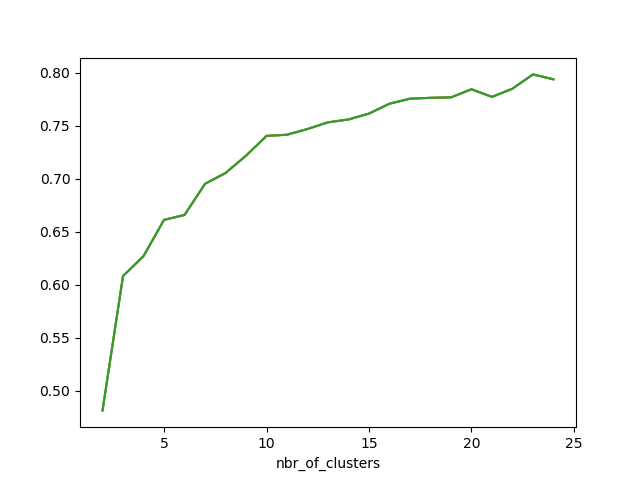

TypeError: legend only accepts two non-keyword arguments

In [22]:
%%time

v_score_Kmeans = []
hom_Kmeans = []
comp_Kmeans = []

l = 25
s = 2

for i in range(s,l):
    nbr_clusters = i
    lb_partition,_,_,_ = partition(data_test_nbr3,nbr_clusters)
    scr_interval = np.ceil(400/i).astype(int)  #A way to normalize how many faults the different clustering batches should have
    scrambled_partition = scramble_edges(lb_partition,scr_interval)
    
    v_score = metrics.v_measure_score(scrambled_partition, lb_partition, beta=1.0)
    homogeneity = metrics.homogeneity_score(scrambled_partition, lb_partition)
    completeness = metrics.completeness_score(scrambled_partition, lb_partition)
    
    v_score_Kmeans.append(v_score)
    hom_Kmeans.append(homogeneity)
    comp_Kmeans.append(completeness)
    
    print(str(i-1) + ' / ' + str(l-1) + ' V_score: ' + str(v_score))
    
x = range(s,l)
plt.figure()
plt.plot(x,v_score_Kmeans, label = 'V-score')
plt.plot(x,hom_Kmeans, label = 'Homogeneity')
plt.plot(x,comp_Kmeans, label = 'Completeness')
#plt.ylabel('Value')
plt.xlabel('nbr_of_clusters')
plt.legend('V-score','Homogeneity','Completeness')
#plt.savefig('V_score_kmeans.png',format = 'png')

In [33]:
comp_Kmeans

[0.48153784594541327,
 0.6083611851694379,
 0.6270915312695698,
 0.6613188954541083,
 0.6659028204565384,
 0.6952936635601101,
 0.7054738561769243,
 0.7218417330727356,
 0.7405107674092243,
 0.741622712891151,
 0.7470325354168564,
 0.7533097644763427,
 0.755998271017875,
 0.7615941272790268,
 0.7708754908458395,
 0.7756319403428338,
 0.7764276152145071,
 0.7768511101377915,
 0.7845300619580454,
 0.7773011771287763,
 0.7850687706304497,
 0.7985357448945467,
 0.793900479765733]

<IPython.core.display.Javascript object>


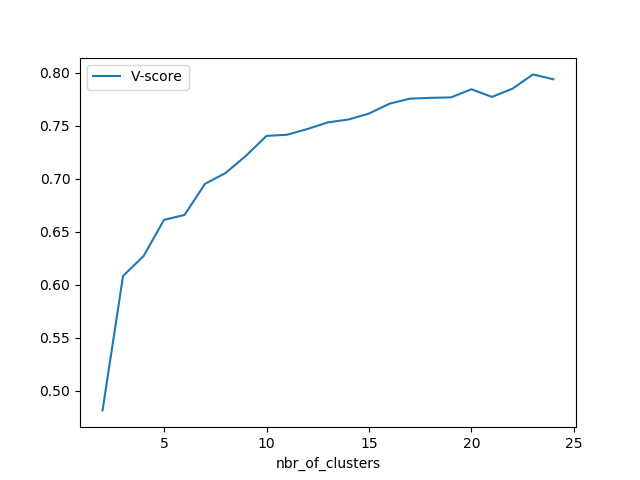

In [31]:
plt.figure()
plt.plot(x,v_score_Kmeans, label = 'V-score')
#plt.plot(x,hom_Kmeans, label = 'Homogeneity')
#plt.plot(x,comp_Kmeans, label = 'Completeness')
#plt.ylabel('Value')
plt.xlabel('nbr_of_clusters')
plt.legend(loc="upper left")

In [ ]:
plt.figure()
plt.plot(x,v_score_Kmeans)
plt.ylabel('V-score')
plt.xlabel('nbr_of_clusters')

## Other measures:

## Kmeans:

<IPython.core.display.Javascript object>


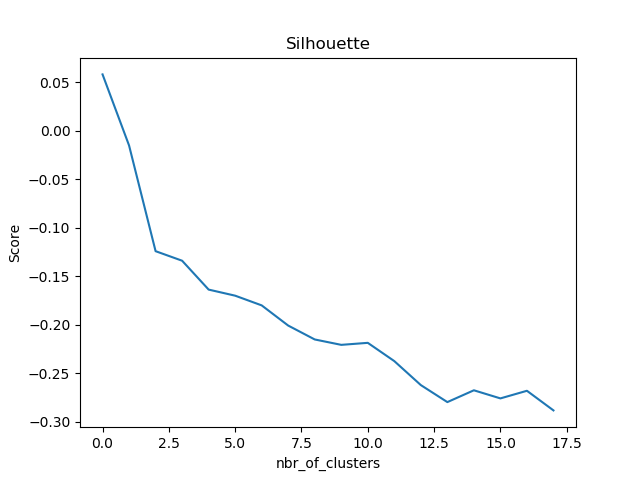

<IPython.core.display.Javascript object>


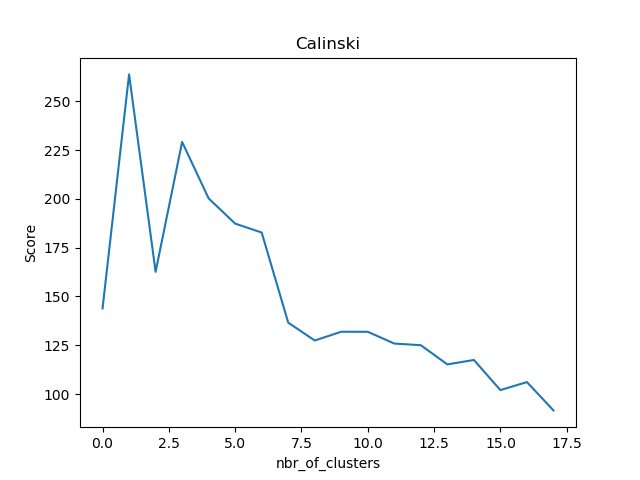

<IPython.core.display.Javascript object>


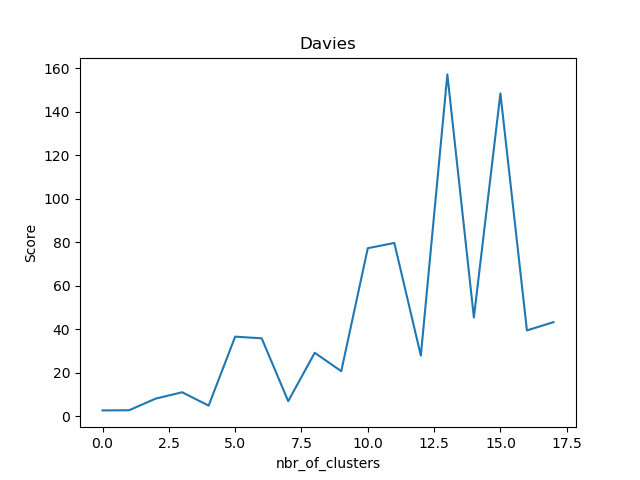

Wall time: 4min 9s


In [40]:
%%time

score_silouette = []
score_calinski = []
score_davies = []

for i in range(2,20):
    label,_,_,_ = partition(data_test_nbr3,i)
    s = metrics.silhouette_score(data_test_nbr3, label, metric='euclidean')
    c = metrics.calinski_harabasz_score(data_test_nbr3, label)
    d = davies_bouldin_score(data_test_nbr3, label)
    
    score_silouette.append([s])
    score_calinski.append([c])
    score_davies.append([d])
    
plt.figure()
plt.plot(range(len(score_silouette)),score_silouette) # High score = good
plt.title('Silhouette')
plt.ylabel('Score')
plt.xlabel('nbr_of_clusters')
#plt.savefig("silhouette.png",format="png")

plt.figure()
plt.plot(range(len(score_calinski)),score_calinski)  # High score = good
plt.title('Calinski')
plt.ylabel('Score')
plt.xlabel('nbr_of_clusters')
#plt.savefig("calinski.png",format="png")

plt.figure()
plt.plot(range(len(score_davies)),score_davies)  # Low score = good (i.e close to zero)
plt.title('Davies')
plt.ylabel('Score')
plt.xlabel('nbr_of_clusters')
#plt.savefig("davies.png",format="png")

## GMM:

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


<IPython.core.display.Javascript object>


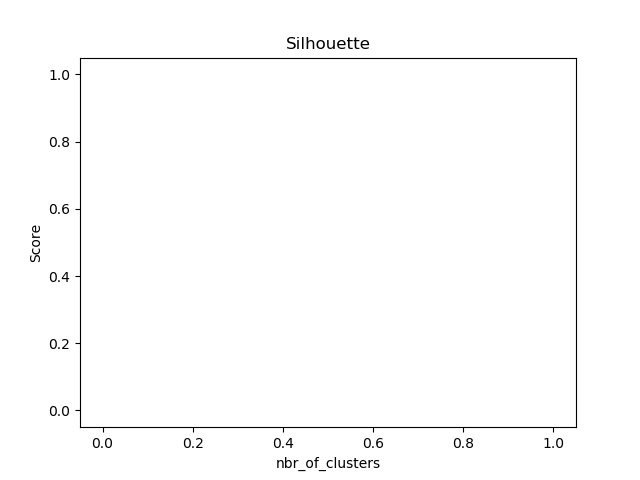

<IPython.core.display.Javascript object>


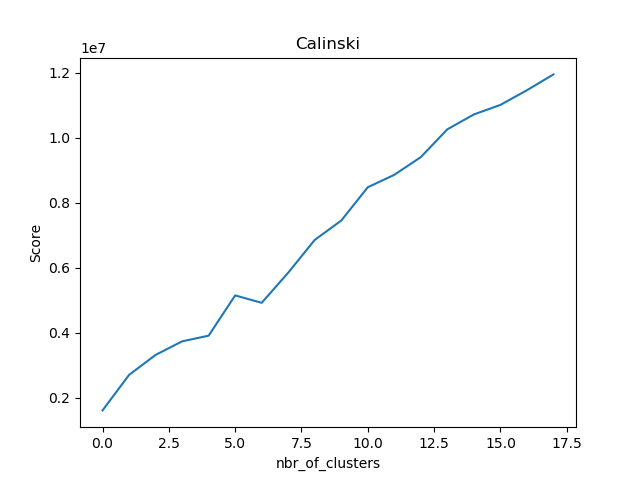

<IPython.core.display.Javascript object>


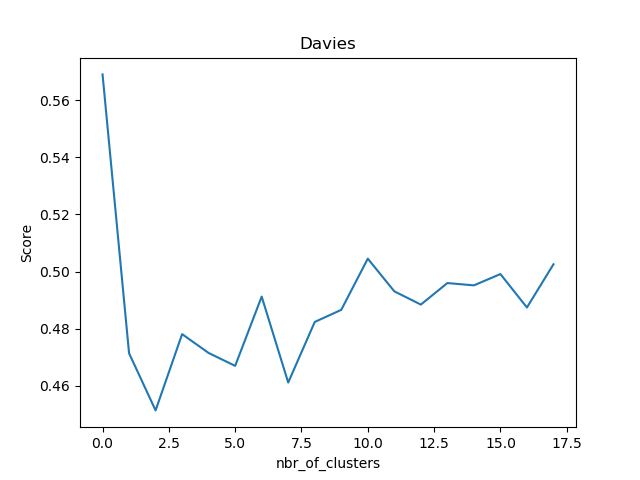

Wall time: 2min 16s


Text(0.5, 0, 'nbr_of_clusters')

In [39]:
%%time

score_silouette = []
score_calinski = []
score_davies = []

for i in range(2,20):
    print(i)
    g = mixture.GaussianMixture(n_components=i,covariance_type='full')
    g.fit(scaled_price)
    label = g.predict(scaled_price)
    #s = metrics.silhouette_score(scaled_price, label, metric='euclidean')
    c = metrics.calinski_harabasz_score(scaled_price, label)
    d = davies_bouldin_score(scaled_price, label)
    
    #score_silouette.append([s])
    score_calinski.append([c])
    score_davies.append([d])
    
plt.figure()
plt.plot(range(len(score_silouette)),score_silouette) # High score = good
plt.title('Silhouette')
plt.ylabel('Score')
plt.xlabel('nbr_of_clusters')
#plt.savefig("sil.png",format="png")

plt.figure()
plt.plot(range(len(score_calinski)),score_calinski)  # High score = good
plt.title('Calinski')
plt.ylabel('Score')
plt.xlabel('nbr_of_clusters')
#plt.savefig("cal.png",format="png")


plt.figure()
plt.plot(range(len(score_davies)),score_davies)  # Low score = good (i.e close to zero)
plt.title('Davies')
plt.ylabel('Score')
plt.xlabel('nbr_of_clusters')
#plt.savefig("dav.png",format="png")